# Rohaan Advani - N19682109 - rna3535

# Gradient Descent Optimization

In ``demo_breast_cancer.ipynb``, we used the `sklearn` built-in `LogisticRegression` class to find the weights for the logistic regression problem.   The `fit` routine in that class has an *optimizer* to select the weights to best match the data.  To understand how that optimizer works, in this demo, we will build a very simple gradient descent optimizer from scratch.  You practice:
* Computing the gradients of a loss function and implementing the gradient calculations in Python
* Implement a simple gradient descent optimizer
* Visualize the effect of the learning rate in gradient descent
* Implement an adaptive learning rate algorithm
* Add regularization to the loss minimization problem
* Try out different black-box optimizers in Python

## Loading the Breast Cancer Data

We first load the standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from sklearn import preprocessing

We next load the data from the breast cancer demo.  

In [2]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head()

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


As in the breast cancer demo, we create a data matrix `X` of various features of the breast cancer sample.  The response vector `y` is a binary indicating if each sample is benign or malignant.  

In [3]:
# Get the predictors
xnames = ['thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit']
Xraw = np.array(df[xnames])
# As usual, let's also append an all ones vector onto X to serve as the intercept feature
X = np.concatenate((np.ones((Xraw.shape[0],1)),Xraw),axis=1)

# Get the response.  Convert to a zero-one indicator
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int) # now y has values of 0,1
Iben = (y==0)
Imal = (y==1)

We want to learn the classification rule to predict `y` from `X`.  We will do so with logistic regression.

## Computing the Gradient and Loss Function

Recall that training a logistic function means finding a weight vector $\beta$ for the classification rule:
* Predict 1 for data vector $\vec{x}$ if $\vec{x}^T\vec{\beta} > 0$.
* Predict 0 for data vector $\vec{x}$ if $\vec{x}^T\vec{\beta} \leq 0$.

Let $h_{\vec{\beta}}(\vec{x}) = \frac{1}{1 + e^{-\vec{x}^T\vec{\beta}}}$. To find $\beta$, we minimize the cross-entropy loss (aka the logistic loss):
$$
L(\vec{\beta}) = - \sum_{i=1}^n y_i \log(h_{\vec{\beta}}(\vec{x}_i)) + (1-y_i) \log(1-h_{\vec{\beta}}(\vec{x}_i)).
$$
One issue with the expresion above for $L$ is that it can be *numerically unstable*. Essentially what can happen is you end up taking logs of numbers very close to zero and Python will return NaNs due to issues with using finite precision arithmetic. To deal with this problem, we write down an alternative expression for `L` which is *mathematically equivalent* but can be computed more accurately in finite precision arithmetic:
$$
L(\vec{\beta}) = \sum_{i=1}^n (1-y_i)(\vec{x}_i^T\vec{\beta}) - \log(h_{\vec{\beta}}(\vec{x}_i)).
$$

As we claimed in class, for this loss function we have
$$
\nabla L(\vec{\beta}) = \mathbf{X}^T(h_{\vec{\beta}}(\mathbf{X}) - y)
$$
where $h_{\vec{\beta}}(\mathbf{X})$ denotes the vector obtained by applying $h$ to every row in $\mathbf{X}$.
    
    
We will first write a function to compute `L` and its gradient `Lgrad`.

In [4]:
def Leval(beta,X,y):
    """
    Compute the loss and gradient given beta,X,y
    """
    z = X@beta
    h = 1/(1+np.exp(-z))
    L = np.sum((1-y)*z - np.log(h))

    # Gradient
    Lgrad = (X.T)@(h-y)
    return L, Lgrad

We can test our function on a random parameter vector $\vec{\beta}_0$.

In [5]:
# Some random point
p = X.shape[1]
beta0 = np.random.randn(p)

# Call the function
L, Lgrad = Leval(beta0,X,y)

It's not ideal that the loss function `L(beta,X,y)` depends on the parameters `X` and `y`.  Most numerical optimizers expect a function that only depends on `beta`, which contains the parameters begin optimized. We can acheive this by using a Python `lambda` function to fix the parameters `X` and `y`.

In [6]:
# Create a function with X,y fixed
Leval_param = lambda beta: Leval(beta,X,y)

# You can now pass a parameter like w0
L0, Lgrad0 = Leval_param(beta0)

### Testing the gradient

Whenever you write a function for computing a gradient, it is very important to test if the gradient is correct.  This is the number one reason people's code does not work with numerical optimizers.  The simplest method is to take two points `beta0` and `beta1` that are close to one another and then verify that:
$$
L(\vec{\beta}_1) - L(\vec{\beta}_0) \approx \langle \nabla L(\vec{\beta}_0), \vec{\beta}_1 - \vec{\beta}_0\rangle.
$$

In [7]:
# Take a random initial point
p = X.shape[1]
beta0 = np.random.randn(p)

# Perturb the point
step = 1e-6
beta1 = beta0 + step*np.random.randn(p)

# Measure the function and gradient at w0 and w1
L0, Lgrad0 = Leval_param(beta0)
L1, Lgrad1 = Leval_param(beta1)

# Predict the amount the function should have changed based on the gradient
dL_est = Lgrad0.T@(beta1-beta0)

# Print the two values to see if they are close
print("Actual L1-L0    = %12.4e" % (L1-L0))
print("Predicted L1-L0 = %12.4e" % dL_est)

Actual L1-L0    =   5.0544e-03
Predicted L1-L0 =   5.0544e-03


You can see that the two agree well. You can run the block multiple times to get different answers (depending on the random choice of $\beta_0$, but you always see agreement.

## A Simple Gradient Descent Optimizer

Now, we build a simple gradient descent optimizer function with a fixed learning rate.

In [8]:
def grad_opt_simp(grad_func, beta0, lr=1e-3,nit=1000):
    """
    Simple gradient descent optimization

    grad_func:  A function that returns the objective function L, and its gradient Leval
    beta0:  Initial estimate for parameters beta
    lr:     learning rate
    nit:    Number of iterations
    """

    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it
    # is useful for debugging
    hist = {'beta': [], 'L': []}

    # initialize
    beta = beta0

    # Loop over iterations
    for it in range(nit):

        # Evaluate the function and gradient
        L, Lgrad = grad_func(beta)

        # Take a gradient step
        beta = beta - lr*Lgrad

         # Save history
        hist['L'].append(L)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('L', 'beta'):
        hist[elem] = np.array(hist[elem])
    return beta, L, hist

We now run the gradient descent starting from a initial condition of $\vec{\beta}_0 = \vec{0}$.

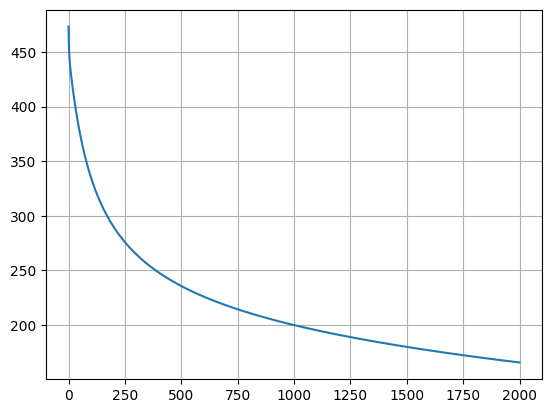

In [9]:
# Initial condition
beta0 = np.zeros(p)

# Parameters
nit = 2000
lr = 1e-5

# Run the gradient descent
beta, L, hist = grad_opt_simp(Leval_param, beta0, lr=lr, nit=nit)

# Plot the training loss
t = np.arange(nit)
plt.plot(t, hist['L'])
plt.grid()

We can measure the accuracy of the final estimate by creating a predict method.

In [10]:
def predict(X,beta):
    z = X@beta
    yhat = (z > 0)
    return (1*yhat)

In [11]:
yhat = predict(X,beta)
acc = np.mean(yhat == y)
print("Train accuracy = %f" % acc)

Train accuracy = 0.941435


This is not quite as good as the accuracy for the `sklearn` method from the demo, which was about 98.5%.  The reason is that the learning rate was somewhat slow and we didn't yet fully converge.

To see the effect of the learning rate, the code below tries different learning rates.

lr=    1.00e-05  Train accuracy = 0.941435
lr=    1.00e-04  Train accuracy = 0.969253
lr=    1.00e-03  Train accuracy = 0.970717


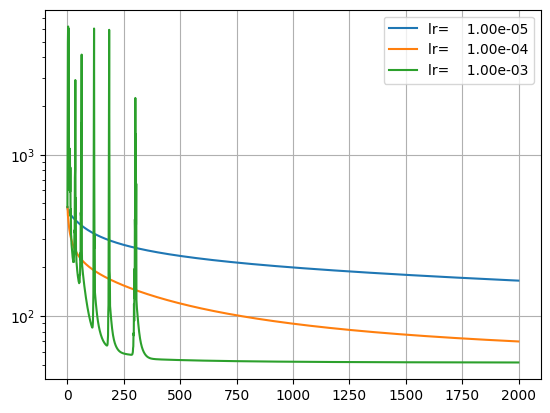

In [12]:
# Learning rate values to test
lr_test = [1e-5,1e-4,1e-3]
ntest = len(lr_test)

# Strings for the legend
leg_str = []

beta0 = np.zeros(p)
for i in range(ntest):
    # Run the optimizer
    beta, L, hist = grad_opt_simp(Leval_param, beta0, lr=lr_test[i], nit=nit)

    # Plot the results
    plt.semilogy(t, hist['L'])
    leg_str.append("lr=%12.2e" % lr_test[i])

    # Measure the train accuracy
    yhat = predict(X,beta)
    acc = np.mean(yhat == y)
    print("lr=%12.2e  Train accuracy = %f" % (lr_test[i], acc))

plt.grid()
plt.legend(leg_str, loc='upper right')

We see that increasing the learning rate, speeds the convergence time, but the optimization is beginning to go unstable. It recovers from this instability for learning rate `1e-3`, but try running with rate `1e-2` to see more of an issue.

## Adaptive Step Size

The above example shows that gradient descent is sensitive to the step size.  We now consider a variant of gradient descent with an adaptive step-size using the Armijo rule discussed in class.

In [13]:
def grad_opt_adapt(grad_func, beta0, nit=2000, lr_init=1e-3):
    """
    Gradient descent optimization with adaptive step size

    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    beta0:  Initial estimate
    nit:    Number of iterations
    lr:     Initial learning rate
    """

    # Set initial point
    beta = beta0
    lr = lr_init

    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it
    # is useful for debugging
    hist = {'lr': [], 'beta': [], 'L': []}

    L,Lgrad = grad_func(beta0)
    for it in range(nit):

        # Take a gradient step
        beta1 = beta - lr*Lgrad

        # Evaluate the test point by computing the objective function, L1,
        # at the test point and the predicted decrease, df_est
        L1, Lgrad1 = grad_func(beta1)
        df_est = Lgrad.T@(beta1-beta)

        # Check if test point passes the Armijo condition
        alpha = 0.5
        if (L1-L < alpha*df_est) and (L1 < L):
            # If descent is sufficient, accept the point and increase the learning rate
            lr = lr*2
            L = L1
            Lgrad = Lgrad1
            beta = beta1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2

        # Save history
        hist['L'].append(L)
        hist['lr'].append(lr)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('L', 'lr', 'beta'):
        hist[elem] = np.array(hist[elem])
    return beta, L, hist


We can now run the new optimizer.

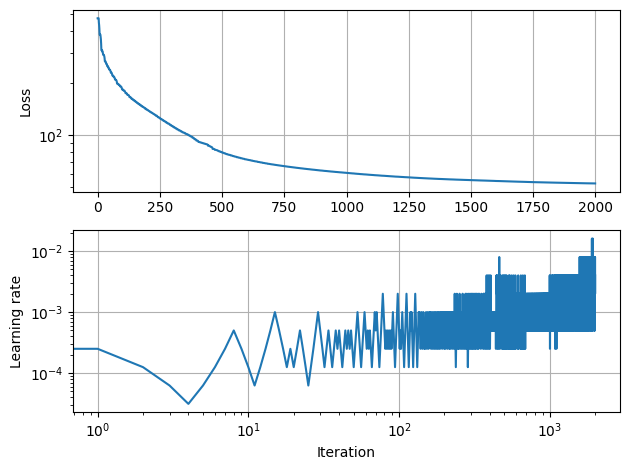

In [14]:
beta0 = np.zeros(p)
nit = 2000
beta, L, hist = grad_opt_adapt(Leval_param, beta0, nit=nit)

t = np.arange(nit)
plt.subplot(2,1,1)
plt.semilogy(t, hist['L'])
plt.grid()
plt.ylabel('Loss')

plt.subplot(2,1,2)
plt.loglog(t, hist['lr'])
plt.grid()
plt.ylabel('Learning rate')
plt.xlabel('Iteration')
plt.tight_layout()

Finally we measure the accuracy and see that we performed as well as the best fixed step size used above.

In [15]:
yhat = predict(X,beta)
acc = np.mean(yhat == y)
print("Train accuracy = %f" % acc)

Train accuracy = 0.970717


## L2 Regularization

Just as for linear regression, given enough features, logsitic regression can be prone to overfitting. In such cases, it often make sense to add regularization when training. In particular, instead of minimizing:
$$
L(\mathbf{\vec{\beta}}) =\sum_{i=1}^n (1-y_i)(\vec{x}_i^T\vec{\beta}) - \log(h_{\vec{\beta}}(\vec{x}_i)).
$$
we might use $\ell_2$ regularization and choose $\beta$ to minimize
$$
L_R(\vec{\beta}) = L(\vec{\beta}) + \lambda \|\vec{\beta}\|_2^2
$$
for some regularization parameter $\lambda$.

Write a function which evaluates the regularized loss `Lr` for parameters `beta` and also computes the gradient $\nabla L_R(\vec{\beta})$ at `beta`. You will have to derive an expression for this gradient to correctly implement your function.

In [16]:
def Leval_reg(beta,X,y,lamb):
    """
    Compute the regularized loss and gradient given beta, X, y, and regularization parameter lamb
    """
    z = X@beta
    h = 1/(1+np.exp(-z))
    L = np.sum((1-y)*z - np.log(h))
    Lr = L + lamb*np.sum(np.square(beta))
    Lrgrad = (X.T)@(h-y)  + 2 * lamb * beta

    return Lr, Lrgrad

As we did above for the unregularized loss, write code to test your gradient computation. Run your test for `lamb` equals `0`,`1`,`10`,`100` and print output which confirms the accuracy of your gradient in all cases.

In [17]:
p = X.shape[1]
beta0 = np.random.randn(p)
step = 1e-6
beta1 = beta0 + step*np.random.randn(p)

Leval_param_reg = lambda beta, lamb: Leval_reg(beta,X,y,lamb)

Lr0, Lrgrad0 = Leval_param_reg(beta0, 0)
Lr1, Lrgrad1 = Leval_param_reg(beta1, 0)
dLr_est = Lrgrad0.T@(beta1-beta0)

print("Actual Lr1-Lr0    = %12.4e" % (Lr1-Lr0))
print("Predicted Lr1-Lr0 = %12.4e" % dLr_est)

Lr0, Lrgrad0 = Leval_param_reg(beta0, 1)
Lr1, Lrgrad1 = Leval_param_reg(beta1, 1)
dLr_est = Lrgrad0.T@(beta1-beta0)

print("Actual Lr1-Lr0    = %12.4e" % (Lr1-Lr0))
print("Predicted Lr1-Lr0 = %12.4e" % dLr_est)

Lr0, Lrgrad0 = Leval_param_reg(beta0, 10)
Lr1, Lrgrad1 = Leval_param_reg(beta1, 10)
dLr_est = Lrgrad0.T@(beta1-beta0)

print("Actual Lr1-Lr0    = %12.4e" % (Lr1-Lr0))
print("Predicted Lr1-Lr0 = %12.4e" % dLr_est)

Lr0, Lrgrad0 = Leval_param_reg(beta0, 100)
Lr1, Lrgrad1 = Leval_param_reg(beta1, 100)
dLr_est = Lrgrad0.T@(beta1-beta0)

print("Actual Lr1-Lr0    = %12.4e" % (Lr1-Lr0))
print("Predicted Lr1-Lr0 = %12.4e" % dLr_est)

Actual Lr1-Lr0    =   2.3117e-04
Predicted Lr1-Lr0 =   2.3117e-04
Actual Lr1-Lr0    =   2.1967e-04
Predicted Lr1-Lr0 =   2.1966e-04
Actual Lr1-Lr0    =   1.1615e-04
Predicted Lr1-Lr0 =   1.1615e-04
Actual Lr1-Lr0    =  -9.1905e-04
Predicted Lr1-Lr0 =  -9.1905e-04


For `lamb` equals `0`,`1`,`10`,`100` use `grad_opt_adapt` run for `2000` iterations with $\vec{\beta}_0 = \vec{0}$ to find a parameter vector $\beta$ which approximately minimizes $L_R(\beta)$. For each regularization level, print the train accuracy achieved when using the optimal parameters. Note that we expect the **train accuracy to decrease** as the regularization parameter increases. Regularization often helps **test accuracy to increase**, but for this lab we're keeping things simple without a test set.

In [18]:
def grad_opt_adapt_l2(grad_func, beta0, lamb, nit=2000, lr_init=1e-3):
    """
    Gradient descent optimization with adaptive step size

    feval:  A function that returns f, fgrad, the objective
            function and its gradient
    beta0:  Initial estimate
    lamb:   Regularization constant
    nit:    Number of iterations
    lr:     Initial learning rate
    """

    # Set initial point
    beta = beta0
    lr = lr_init

    # Create history dictionary for tracking progress per iteration.
    # This isn't necessary if you just want the final answer, but it
    # is useful for debugging
    hist = {'lr': [], 'beta': [], 'L': []}

    L,Lgrad = grad_func(beta0, lamb)
    for it in range(nit):

        # Take a gradient step
        beta1 = beta - lr*Lgrad

        # Evaluate the test point by computing the objective function, L1,
        # at the test point and the predicted decrease, df_est
        L1, Lgrad1 = grad_func(beta1, lamb)
        df_est = Lgrad.T@(beta1-beta)

        # Check if test point passes the Armijo condition
        alpha = 0.5
        if (L1-L < alpha*df_est) and (L1 < L):
            # If descent is sufficient, accept the point and increase the learning rate
            lr = lr*2
            L = L1
            Lgrad = Lgrad1
            beta = beta1
        else:
            # Otherwise, decrease the learning rate
            lr = lr/2

        # Save history
        hist['L'].append(L)
        hist['lr'].append(lr)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('L', 'lr', 'beta'):
        hist[elem] = np.array(hist[elem])
    return beta, L, hist

In [19]:
nit = 2000
beta, L, hist = grad_opt_adapt_l2(Leval_param_reg, beta0, 0, nit=nit)
yhat = predict(X,beta)
acc = np.mean(yhat == y)
print("lamb = 0, Train accuracy = %f" % acc)

nit = 2000
beta, L, hist = grad_opt_adapt_l2(Leval_param_reg, beta0, 1, nit=nit)
yhat = predict(X,beta)
acc = np.mean(yhat == y)
print("lamb = 1, Train accuracy = %f" % acc)

nit = 2000
beta, L, hist = grad_opt_adapt_l2(Leval_param_reg, beta0, 10, nit=nit)
yhat = predict(X,beta)
acc = np.mean(yhat == y)
print("lamb = 10, Train accuracy = %f" % acc)

nit = 2000
beta, L, hist = grad_opt_adapt_l2(Leval_param_reg, beta0, 100, nit=nit)
yhat = predict(X,beta)
acc = np.mean(yhat == y)
print("lamb = 100, Train accuracy = %f" % acc)
# These are the outputs I got:
# lamb = 0, Train accuracy = 0.970717
# lamb = 1, Train accuracy = 0.969253
# lamb = 10, Train accuracy = 0.959004
# lamb = 100, Train accuracy = 0.920937

lamb = 0, Train accuracy = 0.970717
lamb = 1, Train accuracy = 0.969253
lamb = 10, Train accuracy = 0.959004
lamb = 100, Train accuracy = 0.920937


## Stochastic Gradient Descent

As we saw in class, for very large data sets, implementing full gradient descent can be impractical, so stochastic gradient descent is used instead. In this next section, your goal is to implement a stochastic gradient oracle and corresponding stochastic gradient descent iteration to minimize the logistic loss function. Begin by writing a function that computes the gradient of $$
L_j(\vec{\beta}) = (1-y_j)(\vec{x}_j^T\vec{\beta}) - \log(h_{\vec{\beta}}(\vec{x}_j)).
$$
For any $j$. Your function can should take the vector $\vec{x}_j$ and label $y_j\in \{0,1\}$ as input. Note that
$$
L(\vec{\beta}) = \sum_{i=1}^n L_j(\vec{\beta}),
$$
so as shown in class, $n\cdot \mathbb{E}[\nabla L_j(\vec{\beta})] = \nabla L(\vec{\beta})$.

In [20]:
def Leval_stoc(beta,x,y):
    """
    Compute the stochastic gradient given beta, vector x, and single label y
    Note that, unlike before, your function should not compute the loss function value,
    as this would be more expensive then computing the stochastic gradient
    """
    z = x@beta
    h = 1/(1+np.exp(-z))
    Lgrad_stoc = (h - y) * x
    return Lgrad_stoc

Just as we did for our standard gradient oracle, it is a good idea to check that your stochastic gradient is being computed directly. One good way of doing so is verifying that $n\cdot \mathbb{E}[\nabla L_j(\vec{\beta})] = \nabla L(\vec{\beta})$. To do so, we can estimate $\mathbb{E}[\nabla L_j(\vec{\beta})]$ using a large sample of data points and compare to $\nabla L(\vec{\beta})$. Write code to do so below. I estimated $\mathbb{E}[\nabla L_j(\vec{\beta})]$ using 10000 random samples.

In [21]:
def estimate_expected_gradient(beta, X, y, num_samples=10000):
    n, p = X.shape
    avg_gradient = np.zeros(p)

    for _ in range(num_samples):
        # Randomly select a data point
        random_index = np.random.randint(n)
        x_j = X[random_index, :]
        y_j = y[random_index]

        # Compute stochastic gradient for the selected data point
        grad_stoc = Leval_stoc(beta, x_j, y_j)

        # Accumulate the stochastic gradients
        avg_gradient += grad_stoc / num_samples

    return avg_gradient * n  # Scaling to approximate the expected gradient

In [22]:
p = X.shape[1]
beta0 = np.random.randn(p)

# Call the function
L0, Lgrad0 = Leval(beta0,X,y)

# Estimate the expected gradient
expected_gradient = estimate_expected_gradient(beta0, X, y)

# Print the actual gradient and the estimated expected gradient
print("Actual Gradient    =", Lgrad0)
print("Expected Gradient  =", expected_gradient)

Actual Gradient    = [  17.90824234 -583.38767433 -643.0210097  -543.39958771 -361.39064537
 -500.80324352 -644.32147238 -300.88684418 -438.1290917  -256.7688254 ]
Expected Gradient  = [  11.46326497 -627.48509755 -681.59883389 -580.31074868 -372.26854174
 -537.44465894 -684.15768427 -321.33919465 -458.80750978 -266.2198089 ]


With your stochastic gradient oracle implemented, write a basic implementation of stochastic gradient descent with a fixed learning rate. As in our implementation of `grad_opt_simp`, store the history of errors obtained by the algorithm. This will require evaluating our loss function at every iteration, which we would not actually do in practice, since it is computationally expensive. But we will do it here to visualize how the method does.

In [23]:
def stoc_grad_opt(X, y, stoc_grad_func, beta0, lr=1e-3, nit=1000):
    """
    Simple stochastic gradient descent optimization

    stoc_grad_func:  A function that returns the stochastic gradient of the loss for a given input row of X and entry of y
    beta0:  Initial estimate for parameters beta
    lr:     learning rate
    nit:    Number of iterations
    """

    # Create history dictionary for tracking progress per iteration
    hist = {'beta': [], 'L': []}

    # Initialize beta
    beta = beta0

    # Loop over iterations
    for it in range(nit):

        # Randomly shuffle the data
        indices = np.random.permutation(len(y))
        X_shuffled = X[indices, :]
        y_shuffled = y[indices]

        # Evaluate the stochastic gradient and loss for each data point
        for i in range(len(y)):
            x_i = X_shuffled[i, :]
            y_i = y_shuffled[i]

            # Compute stochastic gradient
            Lgrad_stoc = stoc_grad_func(beta, x_i, y_i)

            # Update beta using stochastic gradient
            beta = beta - lr * Lgrad_stoc

        # Evaluate the overall loss after each iteration
        L, _ = Leval(beta, X, y)

        # Save history
        hist['L'].append(L)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('L', 'beta'):
        hist[elem] = np.array(hist[elem])

    return beta, L, hist

Run your stochastic gradient descent method starting from initial condition $\boldsymbol{\beta}_0 = \vec{0}$ and plot the output. Feel free to experiment with different learning rates. Notice that even for small learning rates, the loss does not necessarily decrease monotonically due to randomness inherent in the method.

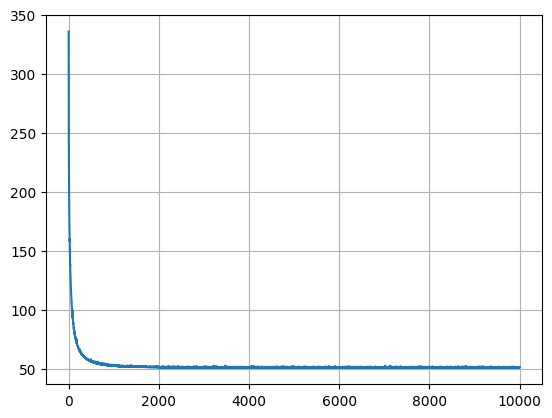

In [24]:
# Initial condition
beta0 = np.zeros(p)

# Parameters
nit = 10000
lr = 1e-3

# Run the gradient descent
beta, L, hist = stoc_grad_opt(X, y, Leval_stoc, beta0, lr=lr, nit=nit)

# Plot the training loss
t = np.arange(nit)
plt.plot(t, hist['L'])
plt.grid()

### Stochastic Gradient Descent Comparison

Rewrite your stochastic gradient descent method above to take in a number of epochs of training instead of number of iterations, and change the code so that it only computes the loss function value at the end of each epoch.

In [25]:
def stoc_grad_opt_epoch(X, y, stoc_grad_func, beta0, lr=1e-3, nepoch=500):
    """
    Simple stochastic gradient descent optimization

    stoc_grad_func:  A function that returns the stochastic gradient of the loss for a given input row of X and entry of y
    beta0:  Initial estimate for parameters beta
    lr:     learning rate
    nepoch: Number of epochs of training
    """

    # Create history dictionary for tracking progress per epoch
    hist = {'beta': [], 'L': []}

    # Initialize beta
    beta = beta0

    # Loop over epochs
    for epoch in range(nepoch):

        # Randomly shuffle the data
        indices = np.random.permutation(len(y))
        X_shuffled = X[indices, :]
        y_shuffled = y[indices]

        # Iterate through the shuffled data to compute the stochastic gradient
        for i in range(len(y)):
            x_i = X_shuffled[i, :]
            y_i = y_shuffled[i]

            # Compute stochastic gradient
            Lgrad_stoc = stoc_grad_func(beta, x_i, y_i)

            # Update beta using stochastic gradient
            beta = beta - lr * Lgrad_stoc

        # Evaluate the overall loss after each epoch
        L, _ = Leval(beta, X, y)

        # Save history at the end of each epoch
        hist['L'].append(L)
        hist['beta'].append(beta)

    # Convert to numpy arrays
    for elem in ('L', 'beta'):
        hist[elem] = np.array(hist[elem])

    return beta, L, hist

Run both your stochastic gradient descent method and the standard gradient descent method with adaptive step size (`grad_opt_adapt`) for 500 epochs.

Plot the loss function errors obtained at the end of each epoch. You should see that, for an appropriate choice of step size, stochastic gradient descent requires fewer epochs to reach near minimal loss in comparison to standard gradient descent. For example, the plot I obtained looked as follows:

<img src="https://www.chrismusco.com/machinelearning2023_grad/sgd_loss.png" width="500"/>


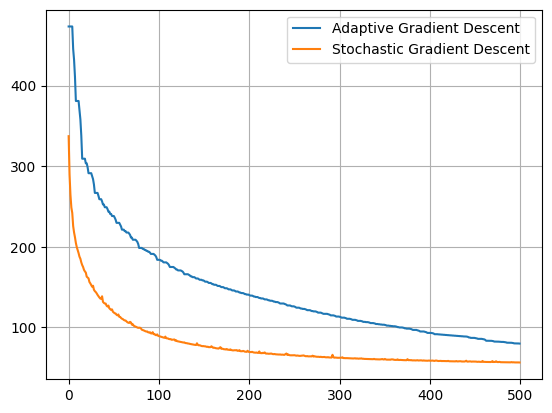

In [26]:
# Initial condition
beta0 = np.zeros(p)

lr = 1e-3
nepoch = 500

# Run the gradient descent
beta, L, hist = stoc_grad_opt_epoch(X, y, Leval_stoc, beta0, lr=lr, nepoch=nepoch)
beta1, L1, hist1 = grad_opt_adapt(Leval_param, beta0, nit=nepoch, lr_init=lr)

# Plot the training loss
t = np.arange(nepoch)
plt.plot(t, hist1['L'], label='Adaptive Gradient Descent')
plt.plot(t, hist['L'], label='Stochastic Gradient Descent')
plt.legend()
plt.grid()